In [1]:
%matplotlib inline
import local_broom

Added 'quench/' and 'quench/libraries' for easy importing.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from qcodes import Station, Instrument
from scipy.signal import find_peaks
from tqdm import tqdm

from monty import Monty
from liveplot import LivePlot, LiveContourPlot
import feedback
import swiper
import MDAC
from fridge import Fridge

# Import the neighbouring files. In may/
import may.dots as dots
from may.custom_devices import connect_to_gb, newSiDot

In [3]:
#%% Connect to instruments

# close any open instruments 
try:
    mdac = Instrument.find_instrument("mdac")
    mdac.close()
except KeyError:
    print('Attempting to remove instrument with name mdac. Does not exist')
    
try:
    lockin = Instrument.find_instrument("sr860_top")
    lockin.close()
except KeyError:
    print("Cannot remove instrument with name sr860_top. Does not exist")

scfg = Station(config_file='/Users/LD2007/Documents/Si_CMOS_james/measurements/system.yaml')

mdac = MDAC.MDAC('mdac', 'ASRL11::INSTR')
lockin = scfg.load_instrument('sr860_top')

# Create our custom MDAC mappings
gb_control_si = connect_to_gb(mdac)
si = newSiDot(mdac)
fridge = Fridge("BlueFors_LD")

Attempting to remove instrument with name mdac. Does not exist
Cannot remove instrument with name sr860_top. Does not exist
Connected to: QNL Sydney MDAC (serial:0x32353532353551040030003E, firmware:1.8) in 4.86s
Connected to: Stanford_Research_Systems SR860 (serial:004279, firmware:V1.51) in 0.13s
Loading GB driver and connecting
Manually Open Breakout_box_top_ch15_LCB
Manually Open Breakout_box_bot_ch09_RCB
Manually Open Breakout_box_bot_ch17_RG
Manually Open Breakout_box_top_ch17_ResB
Manually Open Breakout_box_top_ch19_P3
Manually Open Breakout_box_top_ch13_P2
Manually Open Breakout_box_top_ch04_P1
Manually Open Breakout_box_top_ch02_SETB
Manually Open Breakout_box_bot_ch04_SRB
Manually Open Breakout_box_bot_ch06_SLB
Manually Open Breakout_box_top_ch10_ST
Manually Open Breakout_box_top_ch25_bias
Using base URL https://qphys1114.research.ext.sydney.edu.au/therm_flask/BlueFors_LD


In [4]:
# Connect to magnet

from qcodes.instrument_drivers.oxford.MercuryiPS_VISA import MercuryiPS
magnet = MercuryiPS('magnet15', 'TCPIP0::192.168.0.106::7020::SOCKET')

Connected to: OXFORD INSTRUMENTS MERCURY IPS (serial:162550145, firmware:2.6.04.000) in 0.07s


In [784]:
# Ramp magnet to appropriate point

magnet._set_target_and_ramp('z', 'simul', 0.723)
time.sleep(700) #ramping at approx 1mT/s

In [309]:
experiment = {
    "desc": "Recover and find the regime again. Perform a very large automated parameter sweep"
}

monty = Monty("dc.power recovery", experiment)

Loading existing experiment (ignoring given experiment parameters)
Note that no experimental data has been loaded.
Next run will have id 71


In [14]:
si.ST()
si.SRB(0.95)
si.SLB(0.95)
si.P1(1.9)
si.P2(1.9)
si.ST(3.3)
si.LCB(0.15)
si.RCB(0.15)

In [5]:
dots.get_all_voltages(mdac)

LCB:   0.150004 V
RCB:   0.150003 V
RG:    0.0 V
ResB:  0.0 V
P3:    0.0 V
P2:    2.099998 V
P1:    1.624995 V
SETB:  0.0 V
SRB:   0.929996 V
SLB:   0.930001 V
ST:    3.569998 V
bias:  0.0 V
VSS1P8:      0.0 V
VSS1P0:      0.0 V
VDD1P8:      1.800005 V
VDD1P0:      0.999996 V
VDD1P8_ANA:  1.8 V
BGN1P0:      0.0 V
BGN1P8:      0.0 V
BGP1P0:      0.0 V
BGP1P8:      0.0 V
RST:         1.799996 V
MOSI:        0.0 V
SCLK:        0.0 V
SS_N:        1.8 V
APBCLK:      0.0 V
VICL:        2.899992 V
VLFG:        0.0 V
VHFG:        0.0 V


In [8]:
si.ST(3.56)

## Sweep ST on SET

In [284]:
si.SLB(0.93)
si.SRB(0.93)

Started new run SET_ST_sweep.12
Sweeping Si28_quantum_dot_ST from 3.2V to 3.7V in 101 points.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:48<00:00,  2.08it/s]


Run finished and took 0:00:57.983968.
Saving to SET_ST_sweep.12.xz
Saving to experiment.yaml


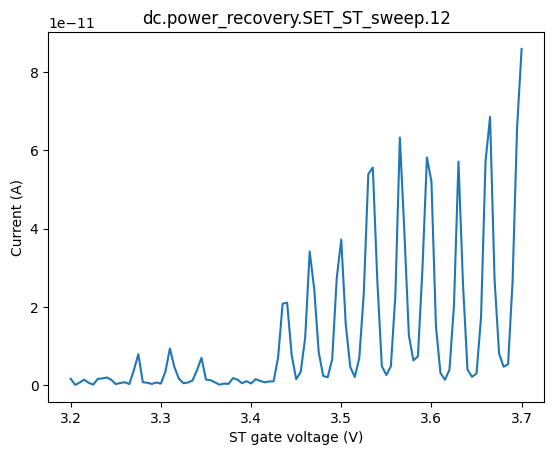

In [778]:
# Get our surroundings

low = 3.2
high = 3.7
pts = 101

parameters = {
    "desc": "Quick 1D scan of the SET over ST",
    "ST":   f"range from {low}v -> {high}v, over {pts} pts",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    }

monty.newrun("SET ST sweep", parameters)
result = swiper.sweep1d(lockin, si.ST, low, high, pts, delay_time=0.3, monty=monty)  # overlap points so we average

monty.save(result)

### Proccess SET result
To find a good feedback point

[ 81 106 146 172 198]


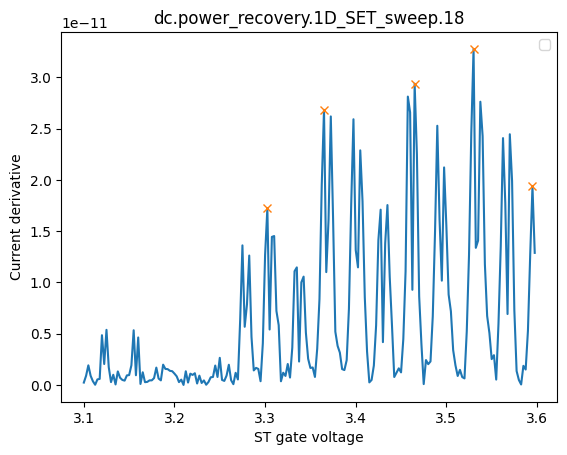

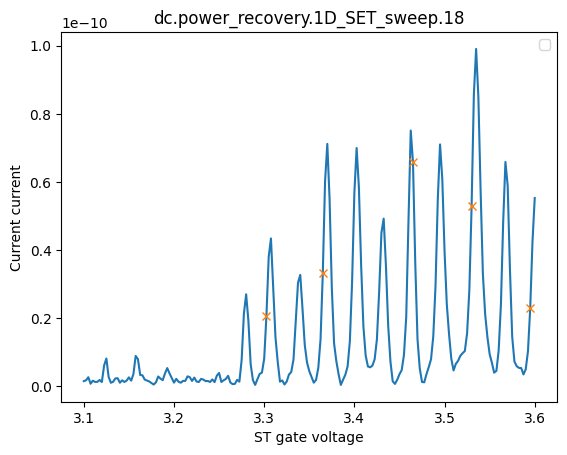

In [194]:
g_range = np.linspace(low, high, pts)
deriv = np.abs(np.diff(result["R"]))
R = result["R"]

peaks, _ = find_peaks(deriv, height=1e-11, distance=20)
#peak = np.argmax(deriv)

fig = plt.figure()
plt.plot(g_range[:-1], deriv)
plt.plot(g_range[peaks], deriv[peaks], "x")
#plt.plot(g_range[peak], deriv[peak], "x")
plt.xlabel("ST gate voltage")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("Current derivative")
plt.legend()

fig = plt.figure()
plt.plot(g_range, R)
plt.plot(g_range[peaks], R[peaks], "x")
#plt.plot(g_range[peak], deriv[peak], "x")
plt.xlabel("ST gate voltage")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("Current current")
plt.legend()

print(peaks)

Best peak at inx = 172
Corresponds to ST=3.5300000000000002 and lockin=5.2897453778e-11


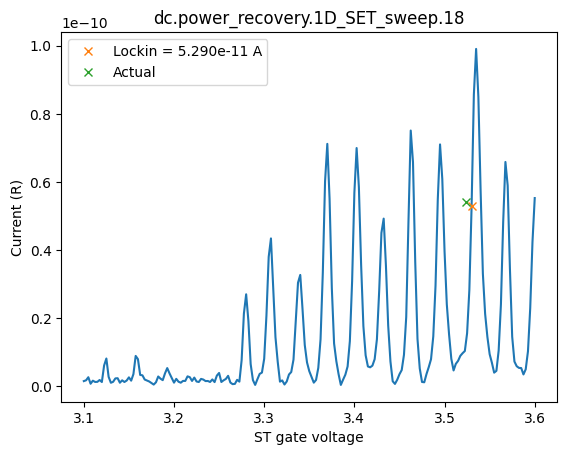

In [201]:
# choose the appropriate peak here
peak = peaks[3]

st_start = g_range[peak]
fix_lockin = result['R'][peak]  # current value to lock in at

print(f"Best peak at inx = {peak}")
print(f"Corresponds to ST={st_start} and lockin={fix_lockin}")

fig = plt.figure()
plt.plot(g_range, result["R"])
plt.plot(g_range[peak], result["R"][peak], "x", label=f"Lockin = {fix_lockin:1.3e} A")

# add where we are now
plt.plot(si.ST(), lockin.R(), "x", label="Actual")

# add our target point
#plt.plot(3.848668, target, "x")

plt.xlabel("ST gate voltage")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("Current (R)")
plt.legend()

In [286]:
# go to the target
st_start = 3.5

si.ST(st_start)
time.sleep(1)
lockin.R()

#%% Lock in on target

target = 6e-11 #fix_lockin
tol = 0.001e-10

In [701]:
def feedback(gate, lockin, target: float, stepsize=0.001, slope="up"):
    """
    Apply proportional feedback blindly
    """
    if slope == "up":
        sgn = 1
    elif slope == "down":
        sgn = -1
    else:
        raise (f"Unknown slope '{slope}'. Must be either 'up' or 'down'")

    r = lockin.R()
    error = (target - r) * sgn
    adjust = error / target * stepsize  # normalised error func
    g = gate() + adjust  # new gate voltage

    upperbound = 3.6
    lowerbound = 3.3

    if g > upperbound:  # upper bound
        print(f"Aborting feedback: correction voltage exceeds threshold, {g} > {upperbound}. No change to ST.")
    elif g < lowerbound:  # lower bound
        print(f"Aborting feedback: correction voltage fails to meet threshold, {g} < {lowerbound}. No change to ST.")
    #elif np.abs(r-target) > 0.03e-10:  # take a small step if good
    #    print(f"small step {np.abs(r-target)}")
    #    gate(gate() + adjust/4)
    #    time.sleep(0.5)
    else:
        gate(g)
        time.sleep(0.5)

def gettotarget():  # inherit global variables (bad!!!!)
    print(f"Target = {target:.4e}, tol = {tol}, initial ST = {si.ST()}")
    while np.abs(lockin.R()-target) > tol:
        feedback(si.ST, lockin, target, stepsize=0.001, slope="up")
        print(f"\rST = {si.ST():.4e}, lockin = {lockin.R():.4e}, delta = {np.abs(lockin.R()-target):.4e}", end="")
        time.sleep(0.1)
    print(f"\nFinal ST = {si.ST()}")

In [164]:
si.ST(3.23)

In [200]:
gettotarget()

Target = 5.2897e-11, tol = 1e-13, initial ST = 3.530003
ST = 3.5241e+00, lockin = 5.4099e-11, delta = 1.1307e-12
Final ST = 3.524118


## Load/Unload dot methods

In [261]:
# flush dots 
#dots.flushdots(si, low=1.0, high=1.9)

low = 1.0
high = 1.75

tic = time.time()
si.P1(low)
si.P2(low)
print(f"Flushed out to {low}V, raising to {high}V")
time.sleep(0.5)
si.P1(high)
si.P2(high)
print(f"Done. Took {time.time()-tic} seconds.")

Flushed out to 1.0V, raising to 1.75V
Done. Took 59.56040978431702 seconds.


In [235]:
# set P1/P2 load values
si.P1(1.65)
si.P2(1.65)

In [262]:
# load dots
#dots.loaddots(si, high=1.2)

thresh = 1.2

tic = time.time()
si.SETB(thresh)
time.sleep(0.5)
si.SETB(0)
print(f"Done. Took {time.time()-tic} seconds.")

Done. Took 47.71217083930969 seconds.


# Sweeps
## P1 scan 1D

In [785]:
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nST = {si.ST()}")

P1 = 1.624995
P2 = 2.099998
ST = 3.439933


In [789]:
si.ST(3.57)  # when doing a downwards sweep slightly undershoot the target point.

In [773]:
gb_control_si.VICL(2.9)

In [318]:
gettotarget()

Target = 6.0000e-11, tol = 1e-12, initial ST = 3.530003
ST = 3.5379e+00, lockin = 6.0059e-11, delta = 2.8875e-14
Final ST = 3.537872


Started new run P1_scan.35


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [04:52<00:00,  1.17s/it]


Run finished and took 0:04:54.894757.
Saving to P1_scan.35.xz
Saving to experiment.yaml


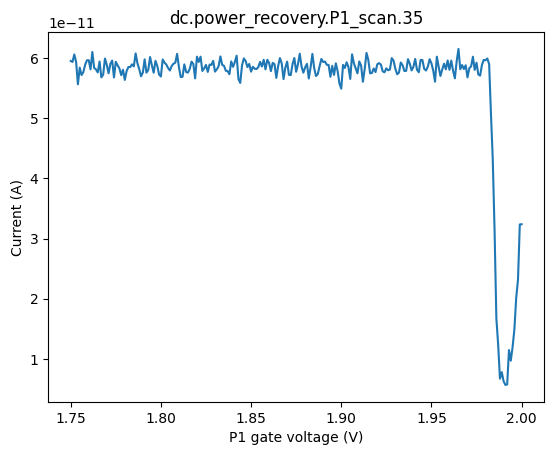

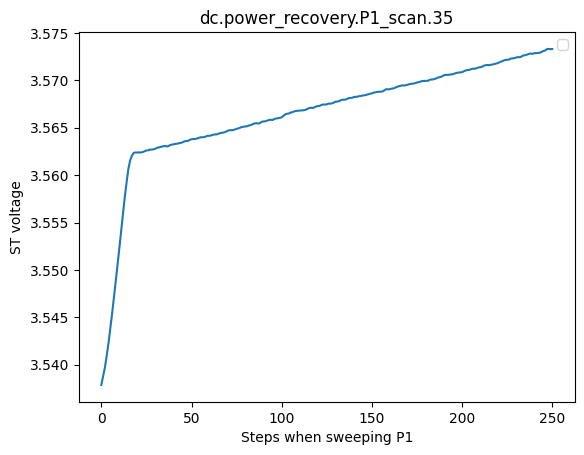

In [320]:
up = False

if up:
    low = 1.75
    high = 2.0
else:
    low = 2.0
    high = 1.75

stepsize = 20e-4
points = 251
gate = si.P1

parameters = {
    "desc": f"1D sweep of P1 (with feedback techniques). Stepsize = {stepsize}",
    "lockin_amplitude": "Set to 10uV",
    "ST":   f"Fixed at {si.ST()}V (target of {target} on lockin)",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    "SETB": f"Fixed at {si.SETB()}V",
    "J1": f"Fixed at {gb_control_si.VICL()}V",
    "P1": f"Ranged from {low}V -> {high}V in {points} points",
    "P2": f"Fixed at {si.P2()}V",
    "temp": f"Mixing chamber {fridge.temp()} K"
    }

monty.newrun("P1 scan", parameters)

#gettotarget()
#time.sleep(2)

# don't use swiper to make modifying the feedback easier

gate_range = np.linspace(low, high, points)
X = np.zeros((points))
Y = np.zeros((points))
R = np.zeros((points))
P = np.zeros((points))
ST_drift = np.zeros(points)
delta_I = np.zeros(points)

#fittedfeedback()

# Move to the start and wait a second for the lockin to catchup
# gate(gate_range[0])
# time.sleep(2.0)
# gettotarget()  # get within tolerance now

with tqdm(total=points) as pbar, LivePlot(gate_range, xlabel="P1 gate voltage (V)", ylabel="Current (A)") as lplot:
    for (j, g) in enumerate(gate_range):
        gate(g)
        
        time.sleep(0.5)
        ST_drift[j] = si.ST()
        X[j] = lockin.X()
        Y[j] = lockin.Y()
        R[j] = lockin.R()
        P[j] = lockin.P()
        pbar.update(1)
        lplot.update(R)
        
        feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")


swiper.plotsweep1d(gate_range, R, gate.name, monty)
monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift, 'ST_I': delta_I})

# Plot ST history over time
fig = plt.figure()
plt.plot(ST_drift)
# plt.plot(delta_I)
plt.xlabel("Steps when sweeping P1")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("ST voltage")
plt.legend()
monty.savefig(plt, "ST history")

In [189]:
si.ST(3.36)

In [ ]:
# Plot ST history over time
fig = plt.figure()
# plt.plot(ST_drift)
plt.plot(delta_I)
# plt.xlabel("Steps when sweeping P1")
# plt.title(monty.identifier + "." + monty.runname)
# plt.ylabel("ST voltage")
# plt.legend()
# monty.savefig(plt, "ST history")

## Detuning scan

In [779]:
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nST = {si.ST()}")

P1 = 2.1
P2 = 1.624996
ST = 3.700005


In [762]:
si.P2(2.1)
si.P1(1.625)
gb_control_si.VICL(2.9)

In [780]:
si.ST(3.42)
gettotarget()

Target = 4.0000e-11, tol = 1e-13, initial ST = 3.419999
ST = 3.4264e+00, lockin = 3.9675e-11, delta = 3.0263e-13
Final ST = 3.426394


Started new run detuning_scan.87


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [05:54<00:00,  1.18s/it]


Run finished and took 0:05:55.474985.
Saving to detuning_scan.87.xz
Saving to experiment.yaml


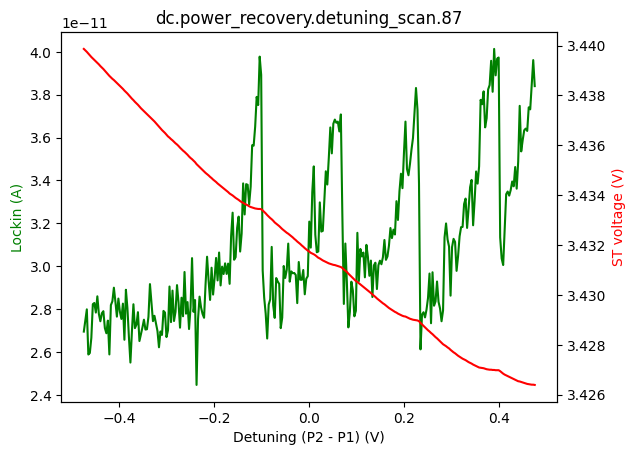

In [781]:
low = 1.625
high = 2.10
points = 301
stepsize = 2e-4 # 5e-4

# choose which gates are going up/down
forward = False
if forward:
    gateup = si.P1
    gatedown = si.P2
else:
    gateup = si.P2
    gatedown = si.P1

parameters = {
    "desc": "Sweep detuning axis (P1 - P2) (feedback)",
    "lockin_amplitude": "Set to 10uV",
    "ST":   f"Fixed at {si.ST()}V (target of {target} on lockin, stepsize = {stepsize})",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    "SETB": f"Fixed at {si.SETB()}V",
    "J1": f"Fixed at {gb_control_si.VICL()}V",
    gateup.name: f"Ranged from {low}V -> {high}V in {points} points",  # P1 or P2
    gatedown.name: f"Ranged from {high}V -> {low}V in {points} points",  # P1 or P2
    "temp": f"Mixing chamber {fridge.temp()} K",
    }

monty.newrun("detuning scan", parameters)

# gate voltage
gate_up_range = np.linspace(low, high, points)
gate_down_range = np.linspace(high, low, points)

# Create detuning axis
detuning = np.linspace(low-high, high-low, points)
if not forward:  # reverse as the data is collected backwards
    detuning = detuning[::-1]

X = np.zeros((points))
Y = np.zeros((points))
R = np.zeros((points))
P = np.zeros((points))
ST_drift = np.zeros(points)

with tqdm(total=points) as pbar, LivePlot(detuning, xlabel="Detuning", ylabel="Current (A)") as lplot:
    for (j, g) in enumerate(gate_up_range):
        gateup(g)
        gatedown(gate_down_range[j])
        time.sleep(0.5)
        
        ST_drift[j] = si.ST()
        X[j] = lockin.X()
        Y[j] = lockin.Y()
        R[j] = lockin.R()
        P[j] = lockin.P()
        
        pbar.update(1)
        lplot.update(R)
        
        feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")


#swiper.plotsweep1d(gate_range, R, gate.name, monty)
monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift})

# Plot everything
fig, ax0 = plt.subplots()
ax1 = ax0.twinx()

ax0.plot(detuning, R, "g-", label="Lockin")
ax0.set_ylabel("Lockin (A)", color="g")

# Plot ST history over time
ax1.plot(detuning, ST_drift, "r-", label="ST gate")
ax1.set_ylabel("ST voltage (V)", color="r")

ax0.set_xlabel(f"Detuning ({gateup.name} - {gatedown.name}) (V)")
ax0.set_title(monty.identifier + "." + monty.runname)

monty.savefig(plt, "detuning")

In [433]:
si.ST()

3.535986

In [689]:
print(si.P1())
print(si.P2())
print(gb_control_si.VICL())

1.650001
2.099998
2.900021


## Charge stability diagram

In [ ]:
# gate 1 stepped over slowly
gate1 = si.P2
low1 = 1.75
high1 = 2.1
points1 = 200

# gate 2 swept frequently
gate2 = si.P1
low2 = 1.75
high2 = 2.1
points2 = 200

stepsize = 12e-4

parameters = {
    "desc": "Sweep both P1 and P2 with feedback present.",
    "lockin_amplitude": "Set to 10uV",
    "ST":   f"Fixed at {si.ST()}V (target of {target} on lockin, stepsize of {stepsize})",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    "SETB": f"Fixed at {si.SETB()}V",
    "J1": f"Fixed at {gb_control_si.VICL()}V",
    gate1.name: f"Ranged from {low1}V -> {high1}V in {points1} points",
    gate2.name: f"Ranged from {low2}V -> {high2}V in {points2} points",
    "temp": f"Mixing chamber {fridge.temp()} K",
    }


monty.newrun("p1 vs p2", parameters)

G1_range = np.linspace(low1, high1, points1)
G2_range = np.linspace(low2, high2, points2)

X = np.zeros((points1, points2))
Y = np.zeros((points1, points2))
R = np.zeros((points1, points2))
P = np.zeros((points1, points2))
ST_drift = np.zeros(points1*points2)
delta_I = np.zeros(points1*points2)


with tqdm(total=points1*points2) as pbar, LiveContourPlot(G2_range, G1_range, xlabel=f"{gate2.name} voltage", ylabel=f"{gate1.name} voltage") as lplot:
    for (j, g1) in enumerate(G1_range):
        gate1(g1)
        time.sleep(0.3)
        #gettotarget()
        time.sleep(1)
        
        for (i, g2) in enumerate(G2_range):
            gate2(g2)
            time.sleep(0.3)
            
            ST_drift[j*points2+i] = si.ST()
            X[j, i] = lockin.X()
            Y[j, i] = lockin.Y()
            R[j, i] = lockin.R()
            P[j, i] = lockin.P()
            
            pbar.update(1)
            lplot.update(R)
            
            feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")
            #delta_I[j*points2+i] = fittedfeedback()
            
        # Flip the direction of the next sweep
        monty.snapshot({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift}) #, "ST_T": delta_I})
        G2_range = G2_range[::-1]
        

swiper.plotsweep2d(G1_range, G2_range, R, gate1.name, gate2.name, monty)  # note wont separate directions
monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift, "ST_T": delta_I})


# Plot ST history over time
fig = plt.figure()
plt.plot(ST_drift)
plt.xlabel("Steps when sweeping P1/P2")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("ST voltage")
plt.legend()
monty.savefig(plt, "ST history")

# Split the 2D sweep into forwad and backward plots

plt.figure()
plt.pcolormesh(G2_range, G1_range[::2], R[::2, :], shading="nearest")  
plt.colorbar()
plt.ylabel(f"{gate1.name} voltage (V)")
plt.xlabel(f"{gate2.name} voltage (V)")
plt.title(monty.identifier + "." + monty.runname + "_forward")
monty.savefig(plt, "stability forward")

plt.figure()
plt.pcolormesh(G2_range, G1_range[1::2], R[1::2, ::-1], shading="nearest")  
plt.colorbar()
plt.ylabel(f"{gate1.name} voltage (V)")
plt.xlabel(f"{gate2.name} voltage (V)")
plt.title(monty.identifier + "." + monty.runname + "_back")
monty.savefig(plt, "stability backward")

## Detuning scan vs J (2D)

In [767]:
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nST = {si.ST()}")

P1 = 2.1
P2 = 1.624996
ST = 3.413633


In [473]:
si.P1(1.7)

In [768]:
si.ST(3.42)
gettotarget()

Target = 4.0000e-11, tol = 1e-13, initial ST = 3.419999
ST = 3.4133e+00, lockin = 3.9697e-11, delta = 2.8393e-13
Final ST = 3.413269


Run finished and took 0:00:26.335324.
Started new run detuning_vs_J.3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30401/30401 [8:31:49<00:00,  1.01s/it]


Run finished and took 8:31:49.876364.
Saving to detuning_vs_J.3.xz
Saving to experiment.yaml


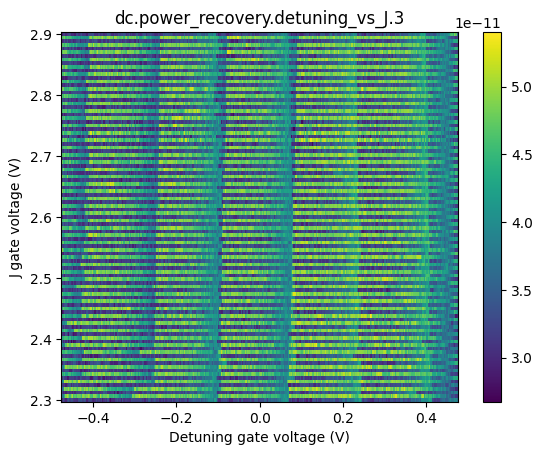

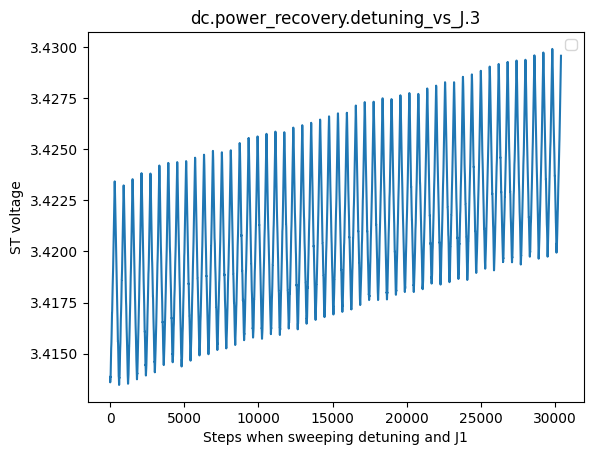

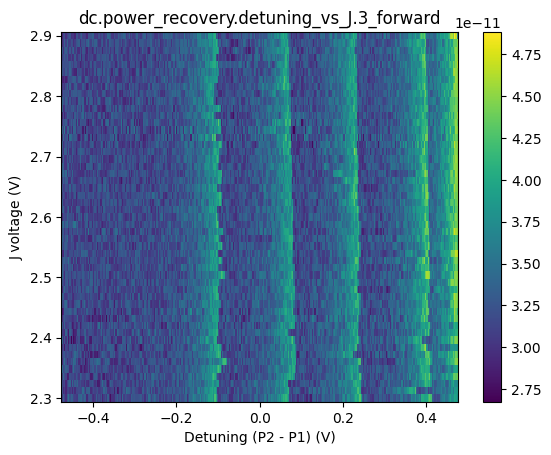

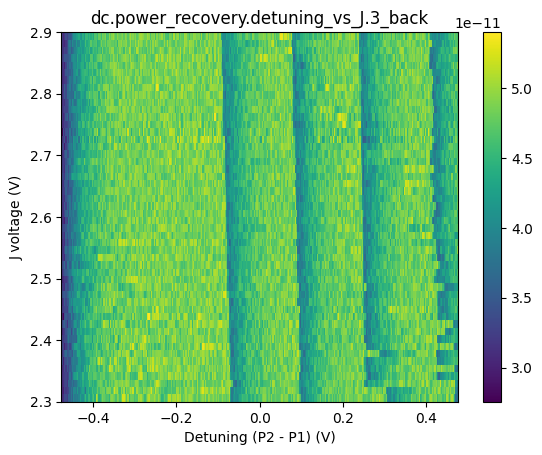

In [770]:
# Setup P1 / P2  detuning params
lowp = 1.625
highp = 2.1
pointsp = 301

# choose which gates are going up/down
forward = False
if forward:
    gateup = si.P1
    gatedown = si.P2
else:
    gateup = si.P2
    gatedown = si.P1

stepsize = 2e-4

# Setup J1 (VICL) (swept slowly)
lowj = 2.9
highj = 2.3
pointsj = 101
gatej = gb_control_si.VICL

parameters = {
    "desc": f"Sweep detuning axis ({gateup.name} - {gatedown.name}) against J1 (VICL)",
    "lockin_amplitude": "Set to 10uV",
    "ST":   f"Start at {si.ST()}V (target of {target} on lockin with stepsize = {stepsize})",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    "SETB": f"Fixed at {si.SETB()}V",
    gateup.name: f"Ranged from {lowp}V -> {highp}V in {pointsp} points",  # P1 or P2
    gatedown.name: f"Ranged from {highp}V -> {lowp}V in {pointsp} points",  # P1 or P2
    "J1": f"Ranged from {lowj}V -> {highj}V in {pointsj} points",
    "temp": f"Mixing chamber {fridge.temp()} K",
    }

monty.newrun("detuning vs J", parameters)

# gate voltages
gate_up_range = np.linspace(lowp, highp, pointsp)
gate_down_range = np.linspace(highp, lowp, pointsp)
j_range = np.linspace(lowj, highj, pointsj)

# Create detuning axis
detuning = np.linspace(lowp-highp, highp-lowp, pointsp)
if not forward:  # reverse as the data is collected backwards (initially)
    detuning = detuning[::-1]

X = np.zeros((pointsj, pointsp))
Y = np.zeros((pointsj, pointsp))
R = np.zeros((pointsj, pointsp))
P = np.zeros((pointsj, pointsp))
ST_drift = np.zeros(pointsj*pointsp)

with tqdm(total=pointsj*pointsp) as pbar, LiveContourPlot(detuning, j_range, xlabel=f"Detuning ({gateup.name} - {gatedown.name}) (V)", ylabel="J gate voltage") as lplot:
    for (j, gj) in enumerate(j_range):
        gatej(gj)  # J1
        time.sleep(0.3)
        feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")
        #gettotarget()  # perhaps be even more agressive on the start of each sweep?
        time.sleep(1)
        
        for (i, g) in enumerate(gate_up_range):
            gateup(g)
            gatedown(gate_down_range[i])
            time.sleep(0.3)
            
            ST_drift[j*pointsp+i] = si.ST()
            X[j, i] = lockin.X()
            Y[j, i] = lockin.Y()
            R[j, i] = lockin.R()
            P[j, i] = lockin.P()
            
            pbar.update(1)
            lplot.update(R)
            
            feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")
            
        monty.snapshot({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift})
        
        # Flip the direction of the next sweep
        gate_up_range = gate_up_range[::-1]
        gate_down_range = gate_down_range[::-1]

monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift}) 


swiper.plotsweep2d(j_range, detuning, R, "J", "Detuning", monty)  # note wont separate directions

# Plot ST history over time
fig = plt.figure()
plt.plot(ST_drift)
plt.xlabel("Steps when sweeping detuning and J1")
plt.title(monty.identifier + "." + monty.runname)
plt.ylabel("ST voltage")
plt.legend()
monty.savefig(plt, "ST history")

# Split the 2D sweep into forwad and backward plots

plt.figure()
plt.pcolormesh(detuning, j_range[::2], R[::2, :], shading="nearest")
plt.colorbar()
plt.ylabel("J voltage (V)")
plt.xlabel(f"Detuning ({gateup.name} - {gatedown.name}) (V)")
plt.title(monty.identifier + "." + monty.runname + "_forward")
monty.savefig(plt, "stability forward")

plt.figure()
plt.pcolormesh(detuning, j_range[1::2], R[1::2, ::-1], shading="nearest")
plt.colorbar()
plt.ylabel("J voltage (V)")
plt.xlabel(f"Detuning ({gateup.name} - {gatedown.name}) (V)")
plt.title(monty.identifier + "." + monty.runname + "_back")
monty.savefig(plt, "stability backward")





# Load and parameter sweep
Sweep the parameter space of loading/unloading electrons and viewing P1 sweeps

In [693]:
def reload(thresh=1.1, p=1.75, j=3.5):
    """
    p = where to raise P1 and P2 to after flushing before reloading
    """
    low = 1.0
    tic = time.time()

    print("Flushing electrons...")
    si.P1(low)
    si.P2(low)
    time.sleep(0.5)

    print("Raising P1 and P2...")
    si.P1(p)
    si.P2(p)
    gb_control_si.VICL(j)

    print("Loading electrons...")
    si.SETB(thresh)
    time.sleep(0.5)
    si.SETB(0)
    print(f"Reloaded in {time.time()-tic} seconds.")

In [485]:
def scan_p1(low=1.75, high=2.0, points=301, gate=si.P1, params=""):
    parameters = {
        "desc": f"Parameter sweep. Loaded electrons with {params}",
        "lockin_amplitude": "Set to 10uV",
        "ST":   f"Fixed at {si.ST()}V (target of {target} on lockin)",
        "SLB":  f"Fixed at {si.SLB()}V",
        "SRB":  f"Fixed at {si.SRB()}V",
        "SETB": f"Fixed at {si.SETB()}V",
        "J1": f"Fixed at {gb_control_si.VICL()}V",
        "P1": f"Ranged from {low}V -> {high}V in {points} points",
        "P2": f"Fixed at {si.P2()}V",
        "temp": f"Mixing chamber {fridge.temp()} K"
        }
    
    monty.newrun(f"P_{params}", parameters)
    
    gate_range = np.linspace(low, high, points)
    X = np.zeros((points))
    Y = np.zeros((points))
    R = np.zeros((points))
    P = np.zeros((points))
    
    with tqdm(total=points) as pbar, LivePlot(gate_range, xlabel="P1 gate voltage (V)", ylabel="Current (A)") as lplot:
        for (j, g) in enumerate(gate_range):
            gate(g)
            
            time.sleep(0.5)
            ST_drift[j] = si.ST()
            X[j] = lockin.X()
            Y[j] = lockin.Y()
            R[j] = lockin.R()
            P[j] = lockin.P()
            pbar.update(1)
            lplot.update(R)
            
            feedback(si.ST, lockin, target, stepsize=5e-11, slope="up")
    
    
    swiper.plotsweep1d(gate_range, R, gate.name, monty)
    monty.save({"X": X, "Y": Y, "R": R, "P": P})

In [489]:
load_setb = np.arange(0.8, 1.3, 0.05)
load_p1p2 = np.arange(1.6, 1.9, 0.1)
load_j = np.arange(3.0, 4.0, 0.2)

In [490]:
len(load_setb) * len(load_p1p2) * len(load_j) * 8/60

20.0

In [488]:
tol=1e-12

Starting new run: SETB0.8 P1.6 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 88.06555962562561 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.521338
ST = 3.5331e+00, lockin = 5.9952e-11, delta = 5.9464e-14
Final ST = 3.533058
Started new run P_up_SETB0.8_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.728350.
Saving to P_up_SETB0.8_P1.6_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:47.587707.
Saving to P_down_SETB0.8_P1.6_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB0.8 P1.6 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 83.14668011665344 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.533058
ST = 3.5317e+00, lockin = 5.9365e-11, delta = 6.2336e-13
Final ST = 3.531683
Started new run P_up_SETB0.8_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.316682.
Saving to P_up_SETB0.8_P1.6_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.318767.
Saving to P_down_SETB0.8_P1.6_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB0.8 P1.6 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 83.13757371902466 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.531683
ST = 3.5306e+00, lockin = 5.9724e-11, delta = 2.8738e-13
Final ST = 3.530602
Started new run P_up_SETB0.8_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:49.277076.
Saving to P_up_SETB0.8_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.349459.
Saving to P_down_SETB0.8_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB0.8 P1.6 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 83.12366461753845 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.530602
ST = 3.5273e+00, lockin = 6.0810e-11, delta = 6.0284e-13
Final ST = 3.527331
Started new run P_up_SETB0.8_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.487950.
Saving to P_up_SETB0.8_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:47.173345.
Saving to P_down_SETB0.8_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB0.8 P1.6 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 83.26378560066223 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.527331
ST = 3.5247e+00, lockin = 6.1227e-11, delta = 1.1914e-12
Final ST = 3.524737
Started new run P_up_SETB0.8_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.312259.
Saving to P_up_SETB0.8_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:47.909990.
Saving to P_down_SETB0.8_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.6 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 86.3951485157013 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.524737
ST = 3.5346e+00, lockin = 6.1100e-11, delta = 1.0792e-12
Final ST = 3.534591
Started new run P_up_SETB0.8500000000000001_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.747531.
Saving to P_up_SETB0.8500000000000001_P1.6_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.886961.
Saving to P_down_SETB0.8500000000000001_P1.6_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.6 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 85.11061930656433 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.534591
ST = 3.5355e+00, lockin = 5.9226e-11, delta = 7.4251e-13
Final ST = 3.535485
Started new run P_up_SETB0.8500000000000001_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.383244.
Saving to P_up_SETB0.8500000000000001_P1.6_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.292710.
Saving to P_down_SETB0.8500000000000001_P1.6_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.6 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 85.09669995307922 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.535485
ST = 3.5319e+00, lockin = 6.0156e-11, delta = 8.9204e-14
Final ST = 3.531889
Started new run P_up_SETB0.8500000000000001_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.803253.
Saving to P_up_SETB0.8500000000000001_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.349764.
Saving to P_down_SETB0.8500000000000001_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.6 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 85.08238768577576 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.531889
ST = 3.5282e+00, lockin = 6.0782e-11, delta = 7.3752e-13
Final ST = 3.528234
Started new run P_up_SETB0.8500000000000001_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.659783.
Saving to P_up_SETB0.8500000000000001_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.222929.
Saving to P_down_SETB0.8500000000000001_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.6 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 85.07004594802856 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.528234
ST = 3.5249e+00, lockin = 6.0964e-11, delta = 7.3188e-13
Final ST = 3.524914
Started new run P_up_SETB0.8500000000000001_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:49<00:00,  1.17s/it]


Run finished and took 0:07:51.992800.
Saving to P_up_SETB0.8500000000000001_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.443486.
Saving to P_down_SETB0.8500000000000001_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.6 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 88.25691676139832 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.524914
ST = 3.5351e+00, lockin = 5.9630e-11, delta = 3.3043e-13
Final ST = 3.535062
Started new run P_up_SETB0.9000000000000001_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:49<00:00,  1.17s/it]


Run finished and took 0:07:51.238881.
Saving to P_up_SETB0.9000000000000001_P1.6_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:49.385231.
Saving to P_down_SETB0.9000000000000001_P1.6_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.6 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 87.38300681114197 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.535062
ST = 3.5357e+00, lockin = 5.9428e-11, delta = 6.1505e-13
Final ST = 3.53573
Started new run P_up_SETB0.9000000000000001_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.257031.
Saving to P_up_SETB0.9000000000000001_P1.6_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.185519.
Saving to P_down_SETB0.9000000000000001_P1.6_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.6 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 87.05920004844666 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.53573
ST = 3.5322e+00, lockin = 5.9977e-11, delta = 1.6526e-14
Final ST = 3.532233
Started new run P_up_SETB0.9000000000000001_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:49.994795.
Saving to P_up_SETB0.9000000000000001_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.457937.
Saving to P_down_SETB0.9000000000000001_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.6 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 87.05515384674072 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.532233
ST = 3.5287e+00, lockin = 6.0102e-11, delta = 1.1495e-13
Final ST = 3.528706
Started new run P_up_SETB0.9000000000000001_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.239157.
Saving to P_up_SETB0.9000000000000001_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.118940.
Saving to P_down_SETB0.9000000000000001_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.6 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 87.07311344146729 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.528706
ST = 3.5252e+00, lockin = 5.9804e-11, delta = 1.6883e-13
Final ST = 3.52515
Started new run P_up_SETB0.9000000000000001_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.466692.
Saving to P_up_SETB0.9000000000000001_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.936603.
Saving to P_down_SETB0.9000000000000001_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.6 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 90.20661473274231 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.52515
ST = 3.5383e+00, lockin = 6.0095e-11, delta = 1.1368e-13
Final ST = 3.538324
Started new run P_up_SETB0.9500000000000002_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.014792.
Saving to P_up_SETB0.9500000000000002_P1.6_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:47.943041.
Saving to P_down_SETB0.9500000000000002_P1.6_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.6 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 89.2822036743164 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.538324
ST = 3.5397e+00, lockin = 6.0540e-11, delta = 5.6371e-13
Final ST = 3.539749
Started new run P_up_SETB0.9500000000000002_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.198028.
Saving to P_up_SETB0.9500000000000002_P1.6_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.237836.
Saving to P_down_SETB0.9500000000000002_P1.6_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.6 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 89.01597023010254 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.539749
ST = 3.5370e+00, lockin = 6.0652e-11, delta = 4.1884e-13
Final ST = 3.536998
Started new run P_up_SETB0.9500000000000002_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.128560.
Saving to P_up_SETB0.9500000000000002_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.245621.
Saving to P_down_SETB0.9500000000000002_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.6 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 89.01097655296326 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.536998
ST = 3.5348e+00, lockin = 6.0980e-11, delta = 9.1947e-13
Final ST = 3.534797
Started new run P_up_SETB0.9500000000000002_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.792232.
Saving to P_up_SETB0.9500000000000002_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.344177.
Saving to P_down_SETB0.9500000000000002_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.6 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 89.04671621322632 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.534797
ST = 3.5317e+00, lockin = 5.8335e-11, delta = 1.5148e-12
Final ST = 3.531653
Started new run P_up_SETB0.9500000000000002_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.243318.
Saving to P_up_SETB0.9500000000000002_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.838402.
Saving to P_down_SETB0.9500000000000002_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.6 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 92.15677618980408 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.531653
ST = 3.5386e+00, lockin = 5.8989e-11, delta = 1.0096e-12
Final ST = 3.53858
Started new run P_up_SETB1.0000000000000002_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.063819.
Saving to P_up_SETB1.0000000000000002_P1.6_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.378100.
Saving to P_down_SETB1.0000000000000002_P1.6_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.6 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 91.00498867034912 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.53858
ST = 3.5397e+00, lockin = 5.9982e-11, delta = 3.6406e-14
Final ST = 3.539739
Started new run P_up_SETB1.0000000000000002_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.404804.
Saving to P_up_SETB1.0000000000000002_P1.6_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.465397.
Saving to P_down_SETB1.0000000000000002_P1.6_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.6 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 90.98478889465332 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.539739
ST = 3.5368e+00, lockin = 5.9156e-11, delta = 7.6320e-13
Final ST = 3.536801
Started new run P_up_SETB1.0000000000000002_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.211757.
Saving to P_up_SETB1.0000000000000002_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.306252.
Saving to P_down_SETB1.0000000000000002_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.6 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 90.97816610336304 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.536801
ST = 3.5348e+00, lockin = 5.9569e-11, delta = 4.1525e-13
Final ST = 3.534846
Started new run P_up_SETB1.0000000000000002_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.958444.
Saving to P_up_SETB1.0000000000000002_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:49.746430.
Saving to P_down_SETB1.0000000000000002_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.6 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 91.01768517494202 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.534846
ST = 3.5319e+00, lockin = 6.0004e-11, delta = 4.6277e-14
Final ST = 3.531879
Started new run P_up_SETB1.0000000000000002_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:49<00:00,  1.17s/it]


Run finished and took 0:07:52.179966.
Saving to P_up_SETB1.0000000000000002_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.272536.
Saving to P_down_SETB1.0000000000000002_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.6 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 94.15169715881348 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.531879
ST = 3.5383e+00, lockin = 5.9949e-11, delta = 4.7318e-14
Final ST = 3.538334
Started new run P_up_SETB1.0500000000000003_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.012565.
Saving to P_up_SETB1.0500000000000003_P1.6_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.618990.
Saving to P_down_SETB1.0500000000000003_P1.6_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.6 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 92.95211434364319 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.538334
ST = 3.5394e+00, lockin = 5.9647e-11, delta = 3.2333e-13
Final ST = 3.539385
Started new run P_up_SETB1.0500000000000003_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.834761.
Saving to P_up_SETB1.0500000000000003_P1.6_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.044710.
Saving to P_down_SETB1.0500000000000003_P1.6_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.6 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 92.96967363357544 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.539385
ST = 3.5376e+00, lockin = 6.2109e-11, delta = 1.9640e-12
Final ST = 3.537587
Started new run P_up_SETB1.0500000000000003_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.341557.
Saving to P_up_SETB1.0500000000000003_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.307514.
Saving to P_down_SETB1.0500000000000003_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.6 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 92.96265602111816 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.537587
ST = 3.5347e+00, lockin = 6.3046e-11, delta = 2.7702e-12
Final ST = 3.534719
Started new run P_up_SETB1.0500000000000003_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.865470.
Saving to P_up_SETB1.0500000000000003_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.472114.
Saving to P_down_SETB1.0500000000000003_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.6 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 93.1883020401001 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.534719
ST = 3.5318e+00, lockin = 5.9197e-11, delta = 7.9626e-13
Final ST = 3.531761
Started new run P_up_SETB1.0500000000000003_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.388323.
Saving to P_up_SETB1.0500000000000003_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.168561.
Saving to P_down_SETB1.0500000000000003_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.6 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 96.09988141059875 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.531761
ST = 3.5384e+00, lockin = 6.0595e-11, delta = 6.2018e-13
Final ST = 3.538432
Started new run P_up_SETB1.1000000000000003_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:49<00:00,  1.17s/it]


Run finished and took 0:07:51.995485.
Saving to P_up_SETB1.1000000000000003_P1.6_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.362399.
Saving to P_down_SETB1.1000000000000003_P1.6_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.6 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 94.92984008789062 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.538432
ST = 3.5395e+00, lockin = 6.0124e-11, delta = 1.4350e-13
Final ST = 3.539483
Started new run P_up_SETB1.1000000000000003_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.112022.
Saving to P_up_SETB1.1000000000000003_P1.6_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.508724.
Saving to P_down_SETB1.1000000000000003_P1.6_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.6 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 94.94247007369995 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.539483
ST = 3.5375e+00, lockin = 6.0840e-11, delta = 7.8583e-13
Final ST = 3.53746
Started new run P_up_SETB1.1000000000000003_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:49<00:00,  1.17s/it]


Run finished and took 0:07:52.479953.
Saving to P_up_SETB1.1000000000000003_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.753987.
Saving to P_down_SETB1.1000000000000003_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.6 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 94.89961886405945 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.53746
ST = 3.5345e+00, lockin = 6.2441e-11, delta = 2.2548e-12
Final ST = 3.534493
Started new run P_up_SETB1.1000000000000003_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.323960.
Saving to P_up_SETB1.1000000000000003_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.196974.
Saving to P_down_SETB1.1000000000000003_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.6 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 94.91482448577881 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.534493
ST = 3.5318e+00, lockin = 5.9423e-11, delta = 5.6581e-13
Final ST = 3.531752
Started new run P_up_SETB1.1000000000000003_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.678003.
Saving to P_up_SETB1.1000000000000003_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.965448.
Saving to P_down_SETB1.1000000000000003_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.6 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 98.08278441429138 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.531752
ST = 3.5388e+00, lockin = 5.9266e-11, delta = 6.5673e-13
Final ST = 3.538766
Started new run P_up_SETB1.1500000000000004_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:49<00:00,  1.17s/it]


Run finished and took 0:07:51.555885.
Saving to P_up_SETB1.1500000000000004_P1.6_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.320020.
Saving to P_down_SETB1.1500000000000004_P1.6_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.6 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 96.87412405014038 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.538766
ST = 3.5393e+00, lockin = 6.0942e-11, delta = 9.4634e-13
Final ST = 3.539297
Started new run P_up_SETB1.1500000000000004_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.108215.
Saving to P_up_SETB1.1500000000000004_P1.6_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:49.551512.
Saving to P_down_SETB1.1500000000000004_P1.6_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.6 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 96.87513208389282 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.539297
ST = 3.5367e+00, lockin = 5.9481e-11, delta = 5.6812e-13
Final ST = 3.536733
Started new run P_up_SETB1.1500000000000004_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.678989.
Saving to P_up_SETB1.1500000000000004_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.257102.
Saving to P_down_SETB1.1500000000000004_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.6 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 96.8811399936676 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.536733
ST = 3.5343e+00, lockin = 5.8861e-11, delta = 1.1302e-12
Final ST = 3.534306
Started new run P_up_SETB1.1500000000000004_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.960535.
Saving to P_up_SETB1.1500000000000004_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.948439.
Saving to P_down_SETB1.1500000000000004_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.6 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 96.88716125488281 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.534306
ST = 3.5314e+00, lockin = 6.0373e-11, delta = 2.1456e-13
Final ST = 3.531408
Started new run P_up_SETB1.1500000000000004_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.874230.
Saving to P_up_SETB1.1500000000000004_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.398314.
Saving to P_down_SETB1.1500000000000004_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.6 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 100.03028082847595 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.531408
ST = 3.5380e+00, lockin = 5.9677e-11, delta = 4.0452e-13
Final ST = 3.537961
Started new run P_up_SETB1.2000000000000004_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:50<00:00,  1.17s/it]


Run finished and took 0:07:52.694363.
Saving to P_up_SETB1.2000000000000004_P1.6_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.448062.
Saving to P_down_SETB1.2000000000000004_P1.6_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.6 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 98.84173369407654 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.537961
ST = 3.5392e+00, lockin = 5.7718e-11, delta = 2.0900e-12
Final ST = 3.539169
Started new run P_up_SETB1.2000000000000004_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.308593.
Saving to P_up_SETB1.2000000000000004_P1.6_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.270344.
Saving to P_down_SETB1.2000000000000004_P1.6_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.6 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 98.86746644973755 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.539169
ST = 3.5371e+00, lockin = 6.0814e-11, delta = 7.3845e-13
Final ST = 3.537106
Started new run P_up_SETB1.2000000000000004_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.743046.
Saving to P_up_SETB1.2000000000000004_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.367765.
Saving to P_down_SETB1.2000000000000004_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.6 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 99.02943754196167 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.537106
ST = 3.5342e+00, lockin = 6.0308e-11, delta = 2.6512e-13
Final ST = 3.534198
Started new run P_up_SETB1.2000000000000004_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.693692.
Saving to P_up_SETB1.2000000000000004_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.599718.
Saving to P_down_SETB1.2000000000000004_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.6 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 98.83133745193481 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.534198
ST = 3.5310e+00, lockin = 5.9698e-11, delta = 3.5624e-13
Final ST = 3.530956
Started new run P_up_SETB1.2000000000000004_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.273566.
Saving to P_up_SETB1.2000000000000004_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.670914.
Saving to P_down_SETB1.2000000000000004_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.6 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 101.98224520683289 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.530956
ST = 3.5372e+00, lockin = 5.8578e-11, delta = 1.3170e-12
Final ST = 3.537194
Started new run P_up_SETB1.2500000000000004_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:49<00:00,  1.17s/it]


Run finished and took 0:07:52.261590.
Saving to P_up_SETB1.2500000000000004_P1.6_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.6_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.048440.
Saving to P_down_SETB1.2500000000000004_P1.6_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.6 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 100.80648565292358 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.537194
ST = 3.5383e+00, lockin = 6.0512e-11, delta = 5.3270e-13
Final ST = 3.538334
Started new run P_up_SETB1.2500000000000004_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.644315.
Saving to P_up_SETB1.2500000000000004_P1.6_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.6_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.815060.
Saving to P_down_SETB1.2500000000000004_P1.6_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.6 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 100.79397106170654 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.538334
ST = 3.5361e+00, lockin = 5.8546e-11, delta = 1.2342e-12
Final ST = 3.536064
Started new run P_up_SETB1.2500000000000004_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:49<00:00,  1.17s/it]


Run finished and took 0:07:52.426080.
Saving to P_up_SETB1.2500000000000004_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.6_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.288718.
Saving to P_down_SETB1.2500000000000004_P1.6_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.6 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 100.80448484420776 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.536064
ST = 3.5328e+00, lockin = 6.1944e-11, delta = 1.7770e-12
Final ST = 3.532822
Started new run P_up_SETB1.2500000000000004_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.643307.
Saving to P_up_SETB1.2500000000000004_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.6_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.405118.
Saving to P_down_SETB1.2500000000000004_P1.6_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.6 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 101.11030650138855 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.532822
ST = 3.5299e+00, lockin = 6.1424e-11, delta = 1.1765e-12
Final ST = 3.529875
Started new run P_up_SETB1.2500000000000004_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.827780.
Saving to P_up_SETB1.2500000000000004_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.6_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.166037.
Saving to P_down_SETB1.2500000000000004_P1.6_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB0.8 P1.7000000000000002 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 88.23184561729431 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.529875
ST = 3.5277e+00, lockin = 5.9870e-11, delta = 5.9794e-14
Final ST = 3.527704
Started new run P_up_SETB0.8_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.002162.
Saving to P_up_SETB0.8_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.096129.
Saving to P_down_SETB0.8_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB0.8 P1.7000000000000002 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 89.03229403495789 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.527704
ST = 3.5250e+00, lockin = 5.9963e-11, delta = 1.3536e-14
Final ST = 3.525041
Started new run P_up_SETB0.8_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:50.319917.
Saving to P_up_SETB0.8_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:49.661571.
Saving to P_down_SETB0.8_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB0.8 P1.7000000000000002 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 89.01911354064941 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.525041
ST = 3.5233e+00, lockin = 6.0765e-11, delta = 7.1355e-13
Final ST = 3.523253
Started new run P_up_SETB0.8_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.344135.
Saving to P_up_SETB0.8_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.507901.
Saving to P_down_SETB0.8_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB0.8 P1.7000000000000002 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 89.0171709060669 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.523253
ST = 3.5202e+00, lockin = 6.2808e-11, delta = 2.6595e-12
Final ST = 3.520159
Started new run P_up_SETB0.8_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.745365.
Saving to P_up_SETB0.8_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:49.987944.
Saving to P_down_SETB0.8_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB0.8 P1.7000000000000002 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 89.05443334579468 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.520159
ST = 3.5163e+00, lockin = 6.1513e-11, delta = 1.4114e-12
Final ST = 3.516258
Started new run P_up_SETB0.8_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.570529.
Saving to P_up_SETB0.8_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.170713.
Saving to P_down_SETB0.8_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.7000000000000002 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 92.16020560264587 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.516258
ST = 3.5257e+00, lockin = 5.9585e-11, delta = 4.3254e-13
Final ST = 3.525719
Started new run P_up_SETB0.8500000000000001_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.063222.
Saving to P_up_SETB0.8500000000000001_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.956427.
Saving to P_down_SETB0.8500000000000001_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.7000000000000002 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 90.9752471446991 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.525719
ST = 3.5270e+00, lockin = 5.9912e-11, delta = 4.1365e-14
Final ST = 3.527016
Started new run P_up_SETB0.8500000000000001_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.508479.
Saving to P_up_SETB0.8500000000000001_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.984590.
Saving to P_down_SETB0.8500000000000001_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.7000000000000002 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 90.98771834373474 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.527016
ST = 3.5236e+00, lockin = 5.8200e-11, delta = 1.6641e-12
Final ST = 3.523558
Started new run P_up_SETB0.8500000000000001_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.949474.
Saving to P_up_SETB0.8500000000000001_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.403775.
Saving to P_down_SETB0.8500000000000001_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.7000000000000002 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 91.14395642280579 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.523558
ST = 3.5201e+00, lockin = 6.2131e-11, delta = 1.9277e-12
Final ST = 3.52011
Started new run P_up_SETB0.8500000000000001_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.335665.
Saving to P_up_SETB0.8500000000000001_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.988685.
Saving to P_down_SETB0.8500000000000001_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.7000000000000002 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 91.00957989692688 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.52011
ST = 3.5163e+00, lockin = 6.0507e-11, delta = 4.1358e-13
Final ST = 3.516308
Started new run P_up_SETB0.8500000000000001_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.570099.
Saving to P_up_SETB0.8500000000000001_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.777079.
Saving to P_down_SETB0.8500000000000001_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.7000000000000002 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 94.15788745880127 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.516308
ST = 3.5278e+00, lockin = 6.0188e-11, delta = 2.2818e-13
Final ST = 3.527782
Started new run P_up_SETB0.9000000000000001_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.590203.
Saving to P_up_SETB0.9000000000000001_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.947310.
Saving to P_down_SETB0.9000000000000001_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.7000000000000002 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 92.94974279403687 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.527782
ST = 3.5273e+00, lockin = 6.0610e-11, delta = 5.4569e-13
Final ST = 3.527301
Started new run P_up_SETB0.9000000000000001_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.511206.
Saving to P_up_SETB0.9000000000000001_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.206454.
Saving to P_down_SETB0.9000000000000001_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.7000000000000002 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 92.96955800056458 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.527301
ST = 3.5256e+00, lockin = 6.0257e-11, delta = 2.0093e-13
Final ST = 3.525631
Started new run P_up_SETB0.9000000000000001_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.818853.
Saving to P_up_SETB0.9000000000000001_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.222635.
Saving to P_down_SETB0.9000000000000001_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.7000000000000002 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 92.94390106201172 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.525631
ST = 3.5231e+00, lockin = 6.0451e-11, delta = 4.7070e-13
Final ST = 3.523067
Started new run P_up_SETB0.9000000000000001_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.633990.
Saving to P_up_SETB0.9000000000000001_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.000693.
Saving to P_down_SETB0.9000000000000001_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.7000000000000002 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 92.97946381568909 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.523067
ST = 3.5207e+00, lockin = 5.9684e-11, delta = 3.0767e-13
Final ST = 3.520699
Started new run P_up_SETB0.9000000000000001_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.187659.
Saving to P_up_SETB0.9000000000000001_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.739491.
Saving to P_down_SETB0.9000000000000001_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.7000000000000002 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 96.1080973148346 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.520699
ST = 3.5322e+00, lockin = 5.9698e-11, delta = 2.0432e-13
Final ST = 3.532184
Started new run P_up_SETB0.9500000000000002_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.044666.
Saving to P_up_SETB0.9500000000000002_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.578261.
Saving to P_down_SETB0.9500000000000002_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.7000000000000002 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 94.94158029556274 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.532184
ST = 3.5336e+00, lockin = 5.8893e-11, delta = 1.0702e-12
Final ST = 3.533608
Started new run P_up_SETB0.9500000000000002_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.051040.
Saving to P_up_SETB0.9500000000000002_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.690314.
Saving to P_down_SETB0.9500000000000002_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.7000000000000002 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 94.88917255401611 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.533608
ST = 3.5309e+00, lockin = 6.0239e-11, delta = 1.9006e-13
Final ST = 3.530897
Started new run P_up_SETB0.9500000000000002_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.004643.
Saving to P_up_SETB0.9500000000000002_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:49.116369.
Saving to P_down_SETB0.9500000000000002_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.7000000000000002 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 95.0812714099884 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.530897
ST = 3.5282e+00, lockin = 5.9970e-11, delta = 1.0746e-14
Final ST = 3.528205
Started new run P_up_SETB0.9500000000000002_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.374449.
Saving to P_up_SETB0.9500000000000002_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.658637.
Saving to P_down_SETB0.9500000000000002_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.7000000000000002 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 95.20863103866577 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.528205
ST = 3.5265e+00, lockin = 5.8497e-11, delta = 1.4152e-12
Final ST = 3.526456
Started new run P_up_SETB0.9500000000000002_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.826741.
Saving to P_up_SETB0.9500000000000002_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:49<00:00,  1.17s/it]


Run finished and took 0:07:52.589830.
Saving to P_down_SETB0.9500000000000002_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.7000000000000002 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 98.08458018302917 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.526456
ST = 3.5313e+00, lockin = 5.9046e-11, delta = 9.0655e-13
Final ST = 3.531319
Started new run P_up_SETB1.0000000000000002_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:49<00:00,  1.17s/it]


Run finished and took 0:07:52.085196.
Saving to P_up_SETB1.0000000000000002_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.448207.
Saving to P_down_SETB1.0000000000000002_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.7000000000000002 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 96.88676881790161 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.531319
ST = 3.5337e+00, lockin = 5.9604e-11, delta = 3.5703e-13
Final ST = 3.533667
Started new run P_up_SETB1.0000000000000002_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.507922.
Saving to P_up_SETB1.0000000000000002_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.335920.
Saving to P_down_SETB1.0000000000000002_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.7000000000000002 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 96.89131689071655 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.533667
ST = 3.5308e+00, lockin = 6.1122e-11, delta = 9.4073e-13
Final ST = 3.530818
Started new run P_up_SETB1.0000000000000002_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.526152.
Saving to P_up_SETB1.0000000000000002_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.971724.
Saving to P_down_SETB1.0000000000000002_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.7000000000000002 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 96.88555431365967 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.530818
ST = 3.5283e+00, lockin = 5.9422e-11, delta = 5.7853e-13
Final ST = 3.528313
Started new run P_up_SETB1.0000000000000002_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.373460.
Saving to P_up_SETB1.0000000000000002_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.364755.
Saving to P_down_SETB1.0000000000000002_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.7000000000000002 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 96.89332795143127 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.528313
ST = 3.5264e+00, lockin = 6.0312e-11, delta = 2.7005e-13
Final ST = 3.526387
Started new run P_up_SETB1.0000000000000002_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.601643.
Saving to P_up_SETB1.0000000000000002_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.940915.
Saving to P_down_SETB1.0000000000000002_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.7000000000000002 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 100.02730250358582 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.526387
ST = 3.5314e+00, lockin = 5.9178e-11, delta = 7.9131e-13
Final ST = 3.531359
Started new run P_up_SETB1.0500000000000003_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.542859.
Saving to P_up_SETB1.0500000000000003_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.856623.
Saving to P_down_SETB1.0500000000000003_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.7000000000000002 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 98.86541247367859 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.531359
ST = 3.5330e+00, lockin = 5.9668e-11, delta = 2.8795e-13
Final ST = 3.533019
Started new run P_up_SETB1.0500000000000003_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:49.965943.
Saving to P_up_SETB1.0500000000000003_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.666405.
Saving to P_down_SETB1.0500000000000003_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.7000000000000002 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 98.84565949440002 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.533019
ST = 3.5308e+00, lockin = 6.0770e-11, delta = 6.9736e-13
Final ST = 3.530848
Started new run P_up_SETB1.0500000000000003_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.613904.
Saving to P_up_SETB1.0500000000000003_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.147213.
Saving to P_down_SETB1.0500000000000003_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.7000000000000002 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 98.85887885093689 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.530848
ST = 3.5279e+00, lockin = 5.9398e-11, delta = 5.8120e-13
Final ST = 3.527881
Started new run P_up_SETB1.0500000000000003_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.252608.
Saving to P_up_SETB1.0500000000000003_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.650488.
Saving to P_down_SETB1.0500000000000003_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.7000000000000002 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 98.84998083114624 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.527881
ST = 3.5262e+00, lockin = 5.9822e-11, delta = 2.2035e-13
Final ST = 3.526211
Started new run P_up_SETB1.0500000000000003_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.921778.
Saving to P_up_SETB1.0500000000000003_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.670667.
Saving to P_down_SETB1.0500000000000003_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.7000000000000002 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 101.9986002445221 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.526211
ST = 3.5315e+00, lockin = 5.8380e-11, delta = 1.5605e-12
Final ST = 3.531535
Started new run P_up_SETB1.1000000000000003_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.518520.
Saving to P_up_SETB1.1000000000000003_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.487915.
Saving to P_down_SETB1.1000000000000003_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.7000000000000002 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 100.83515429496765 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.531535
ST = 3.5333e+00, lockin = 5.9709e-11, delta = 2.3882e-13
Final ST = 3.533304
Started new run P_up_SETB1.1000000000000003_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.762402.
Saving to P_up_SETB1.1000000000000003_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.431412.
Saving to P_down_SETB1.1000000000000003_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.7000000000000002 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 100.79960370063782 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.533304
ST = 3.5307e+00, lockin = 6.0446e-11, delta = 4.7125e-13
Final ST = 3.53074
Started new run P_up_SETB1.1000000000000003_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:52.325413.
Saving to P_up_SETB1.1000000000000003_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.721912.
Saving to P_down_SETB1.1000000000000003_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.7000000000000002 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 100.78769659996033 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.53074
ST = 3.5278e+00, lockin = 5.9979e-11, delta = 1.1287e-13
Final ST = 3.527792
Started new run P_up_SETB1.1000000000000003_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.521087.
Saving to P_up_SETB1.1000000000000003_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.704616.
Saving to P_down_SETB1.1000000000000003_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.7000000000000002 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 100.82016801834106 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.527792
ST = 3.5262e+00, lockin = 6.0642e-11, delta = 6.7577e-13
Final ST = 3.526171
Started new run P_up_SETB1.1000000000000003_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.650771.
Saving to P_up_SETB1.1000000000000003_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.085046.
Saving to P_down_SETB1.1000000000000003_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.7000000000000002 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 103.99978232383728 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.526171
ST = 3.5309e+00, lockin = 5.9944e-11, delta = 2.9929e-14
Final ST = 3.530897
Started new run P_up_SETB1.1500000000000004_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.309914.
Saving to P_up_SETB1.1500000000000004_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.414001.
Saving to P_down_SETB1.1500000000000004_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.7000000000000002 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 102.76654052734375 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.530897
ST = 3.5332e+00, lockin = 5.8884e-11, delta = 1.0043e-12
Final ST = 3.533186
Started new run P_up_SETB1.1500000000000004_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.537280.
Saving to P_up_SETB1.1500000000000004_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.506870.
Saving to P_down_SETB1.1500000000000004_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.7000000000000002 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 102.74328017234802 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.533186
ST = 3.5304e+00, lockin = 5.9636e-11, delta = 3.2890e-13
Final ST = 3.530406
Started new run P_up_SETB1.1500000000000004_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.709510.
Saving to P_up_SETB1.1500000000000004_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.698596.
Saving to P_down_SETB1.1500000000000004_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.7000000000000002 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 103.08087086677551 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.530406
ST = 3.5277e+00, lockin = 6.0100e-11, delta = 1.1929e-13
Final ST = 3.527743
Started new run P_up_SETB1.1500000000000004_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.495555.
Saving to P_up_SETB1.1500000000000004_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.844671.
Saving to P_down_SETB1.1500000000000004_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.7000000000000002 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 102.77047610282898 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.527743
ST = 3.5259e+00, lockin = 6.0257e-11, delta = 3.0158e-13
Final ST = 3.525896
Started new run P_up_SETB1.1500000000000004_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.383580.
Saving to P_up_SETB1.1500000000000004_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.510339.
Saving to P_down_SETB1.1500000000000004_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.7000000000000002 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 105.9155867099762 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.525896
ST = 3.5307e+00, lockin = 5.9843e-11, delta = 1.7089e-13
Final ST = 3.530671
Started new run P_up_SETB1.2000000000000004_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.041965.
Saving to P_up_SETB1.2000000000000004_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.306028.
Saving to P_down_SETB1.2000000000000004_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.7000000000000002 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 104.75030875205994 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.530671
ST = 3.5329e+00, lockin = 5.9611e-11, delta = 3.3934e-13
Final ST = 3.53293
Started new run P_up_SETB1.2000000000000004_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.785601.
Saving to P_up_SETB1.2000000000000004_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.600509.
Saving to P_down_SETB1.2000000000000004_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.7000000000000002 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 104.72896933555603 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.53293
ST = 3.5300e+00, lockin = 5.8352e-11, delta = 1.5476e-12
Final ST = 3.530003
Started new run P_up_SETB1.2000000000000004_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.795952.
Saving to P_up_SETB1.2000000000000004_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:49.426326.
Saving to P_down_SETB1.2000000000000004_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.7000000000000002 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 104.81191992759705 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.530003
ST = 3.5272e+00, lockin = 5.9639e-11, delta = 3.9890e-13
Final ST = 3.527154
Started new run P_up_SETB1.2000000000000004_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.036849.
Saving to P_up_SETB1.2000000000000004_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.924532.
Saving to P_down_SETB1.2000000000000004_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.7000000000000002 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 104.74069094657898 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.527154
ST = 3.5256e+00, lockin = 6.1563e-11, delta = 1.4713e-12
Final ST = 3.525572
Started new run P_up_SETB1.2000000000000004_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.522970.
Saving to P_up_SETB1.2000000000000004_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:49.084575.
Saving to P_down_SETB1.2000000000000004_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.7000000000000002 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 107.90642857551575 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.525572
ST = 3.5307e+00, lockin = 5.9563e-11, delta = 3.7914e-13
Final ST = 3.530749
Started new run P_up_SETB1.2500000000000004_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.107912.
Saving to P_up_SETB1.2500000000000004_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.7000000000000002_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:49.142159.
Saving to P_down_SETB1.2500000000000004_P1.7000000000000002_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.7000000000000002 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 106.7190432548523 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.530749
ST = 3.5308e+00, lockin = 6.0744e-11, delta = 7.0829e-13
Final ST = 3.530789
Started new run P_up_SETB1.2500000000000004_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.174943.
Saving to P_up_SETB1.2500000000000004_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.7000000000000002_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.472520.
Saving to P_down_SETB1.2500000000000004_P1.7000000000000002_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.7000000000000002 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 106.71141362190247 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.530789
ST = 3.5293e+00, lockin = 6.1392e-11, delta = 1.3129e-12
Final ST = 3.529335
Started new run P_up_SETB1.2500000000000004_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.945050.
Saving to P_up_SETB1.2500000000000004_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.7000000000000002_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.032016.
Saving to P_down_SETB1.2500000000000004_P1.7000000000000002_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.7000000000000002 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 106.74294590950012 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.529335
ST = 3.5274e+00, lockin = 6.0608e-11, delta = 6.2869e-13
Final ST = 3.527409
Started new run P_up_SETB1.2500000000000004_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.734763.
Saving to P_up_SETB1.2500000000000004_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.7000000000000002_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.433261.
Saving to P_down_SETB1.2500000000000004_P1.7000000000000002_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.7000000000000002 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 106.69074058532715 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.527409
ST = 3.5248e+00, lockin = 5.9578e-11, delta = 4.6098e-13
Final ST = 3.524786
Started new run P_up_SETB1.2500000000000004_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.611508.
Saving to P_up_SETB1.2500000000000004_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.7000000000000002_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.451673.
Saving to P_down_SETB1.2500000000000004_P1.7000000000000002_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB0.8 P1.8000000000000003 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 94.11290574073792 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.524786
ST = 3.5196e+00, lockin = 6.0785e-11, delta = 7.9725e-13
Final ST = 3.519638
Started new run P_up_SETB0.8_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.405205.
Saving to P_up_SETB0.8_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:48.956437.
Saving to P_down_SETB0.8_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB0.8 P1.8000000000000003 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 94.9548020362854 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.519638
ST = 3.5159e+00, lockin = 6.1579e-11, delta = 1.4682e-12
Final ST = 3.515865
Started new run P_up_SETB0.8_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.200700.
Saving to P_up_SETB0.8_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.222090.
Saving to P_down_SETB0.8_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB0.8 P1.8000000000000003 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 94.9215452671051 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.515865
ST = 3.5142e+00, lockin = 6.0802e-11, delta = 5.8504e-13
Final ST = 3.514195
Started new run P_up_SETB0.8_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.517163.
Saving to P_up_SETB0.8_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.379686.
Saving to P_down_SETB0.8_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB0.8 P1.8000000000000003 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 94.94354557991028 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.514195
ST = 3.5117e+00, lockin = 6.0786e-11, delta = 7.6450e-13
Final ST = 3.511739
Started new run P_up_SETB0.8_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.556442.
Saving to P_up_SETB0.8_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.027071.
Saving to P_down_SETB0.8_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB0.8 P1.8000000000000003 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 94.90147924423218 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.511739
ST = 3.5122e+00, lockin = 5.9989e-11, delta = 8.7946e-14
Final ST = 3.512221
Started new run P_up_SETB0.8_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.143261.
Saving to P_up_SETB0.8_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.829734.
Saving to P_down_SETB0.8_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.8000000000000003 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 98.05456328392029 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.512221
ST = 3.5178e+00, lockin = 5.9144e-11, delta = 7.7115e-13
Final ST = 3.517771
Started new run P_up_SETB0.8500000000000001_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.668884.
Saving to P_up_SETB0.8500000000000001_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.296288.
Saving to P_down_SETB0.8500000000000001_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.8000000000000003 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 96.89713263511658 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.517771
ST = 3.5167e+00, lockin = 5.9874e-11, delta = 1.7942e-13
Final ST = 3.516681
Started new run P_up_SETB0.8500000000000001_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.148007.
Saving to P_up_SETB0.8500000000000001_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.920179.
Saving to P_down_SETB0.8500000000000001_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.8000000000000003 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 96.87333631515503 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.516681
ST = 3.5149e+00, lockin = 6.0333e-11, delta = 1.5131e-13
Final ST = 3.514854
Started new run P_up_SETB0.8500000000000001_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.146083.
Saving to P_up_SETB0.8500000000000001_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.375690.
Saving to P_down_SETB0.8500000000000001_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.8000000000000003 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 96.88407874107361 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.514854
ST = 3.5116e+00, lockin = 6.0316e-11, delta = 2.5212e-13
Final ST = 3.511602
Started new run P_up_SETB0.8500000000000001_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:52.566011.
Saving to P_up_SETB0.8500000000000001_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:49.477197.
Saving to P_down_SETB0.8500000000000001_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB0.8500000000000001 P1.8000000000000003 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 96.8988389968872 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.511602
ST = 3.5126e+00, lockin = 6.0249e-11, delta = 2.3118e-13
Final ST = 3.512584
Started new run P_up_SETB0.8500000000000001_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.796379.
Saving to P_up_SETB0.8500000000000001_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB0.8500000000000001_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.920589.
Saving to P_down_SETB0.8500000000000001_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.8000000000000003 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 100.36775517463684 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.512584
ST = 3.5212e+00, lockin = 5.9463e-11, delta = 5.8579e-13
Final ST = 3.52122
Started new run P_up_SETB0.9000000000000001_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.991290.
Saving to P_up_SETB0.9000000000000001_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.030394.
Saving to P_down_SETB0.9000000000000001_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.8000000000000003 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 98.81557178497314 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.52122
ST = 3.5234e+00, lockin = 5.9981e-11, delta = 1.8862e-14
Final ST = 3.523362
Started new run P_up_SETB0.9000000000000001_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.359055.
Saving to P_up_SETB0.9000000000000001_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.478171.
Saving to P_down_SETB0.9000000000000001_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.8000000000000003 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 98.82723903656006 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.523362
ST = 3.5205e+00, lockin = 6.1586e-11, delta = 1.5262e-12
Final ST = 3.520473
Started new run P_up_SETB0.9000000000000001_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.402835.
Saving to P_up_SETB0.9000000000000001_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.940341.
Saving to P_down_SETB0.9000000000000001_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.8000000000000003 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 98.885183095932 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.520473
ST = 3.5189e+00, lockin = 6.0536e-11, delta = 3.9679e-13
Final ST = 3.518891
Started new run P_up_SETB0.9000000000000001_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:49<00:00,  1.17s/it]


Run finished and took 0:07:52.960463.
Saving to P_up_SETB0.9000000000000001_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.151425.
Saving to P_down_SETB0.9000000000000001_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB0.9000000000000001 P1.8000000000000003 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 99.12584042549133 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.518891
ST = 3.5178e+00, lockin = 5.9673e-11, delta = 3.0893e-13
Final ST = 3.517752
Started new run P_up_SETB0.9000000000000001_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.148626.
Saving to P_up_SETB0.9000000000000001_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9000000000000001_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.508384.
Saving to P_down_SETB0.9000000000000001_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.8000000000000003 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 102.2862823009491 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.517752
ST = 3.5265e+00, lockin = 5.8572e-11, delta = 1.3223e-12
Final ST = 3.526545
Started new run P_up_SETB0.9500000000000002_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.658138.
Saving to P_up_SETB0.9500000000000002_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.727210.
Saving to P_down_SETB0.9500000000000002_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.8000000000000003 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 100.85815811157227 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.526545
ST = 3.5273e+00, lockin = 6.0184e-11, delta = 1.4753e-13
Final ST = 3.527291
Started new run P_up_SETB0.9500000000000002_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.387129.
Saving to P_up_SETB0.9500000000000002_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.851065.
Saving to P_down_SETB0.9500000000000002_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.8000000000000003 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 100.81024050712585 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.527291
ST = 3.5247e+00, lockin = 6.0733e-11, delta = 6.6461e-13
Final ST = 3.524658
Started new run P_up_SETB0.9500000000000002_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.854993.
Saving to P_up_SETB0.9500000000000002_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:49.346798.
Saving to P_down_SETB0.9500000000000002_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.8000000000000003 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 100.80691409111023 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.524658
ST = 3.5223e+00, lockin = 6.1380e-11, delta = 1.2115e-12
Final ST = 3.522291
Started new run P_up_SETB0.9500000000000002_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.814582.
Saving to P_up_SETB0.9500000000000002_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.001252.
Saving to P_down_SETB0.9500000000000002_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB0.9500000000000002 P1.8000000000000003 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 100.83100962638855 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.522291
ST = 3.5204e+00, lockin = 6.0876e-11, delta = 8.5112e-13
Final ST = 3.520365
Started new run P_up_SETB0.9500000000000002_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.672671.
Saving to P_up_SETB0.9500000000000002_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB0.9500000000000002_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.590304.
Saving to P_down_SETB0.9500000000000002_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.8000000000000003 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 103.96133804321289 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.520365
ST = 3.5266e+00, lockin = 6.0256e-11, delta = 2.8360e-13
Final ST = 3.526643
Started new run P_up_SETB1.0000000000000002_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.109173.
Saving to P_up_SETB1.0000000000000002_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.694334.
Saving to P_down_SETB1.0000000000000002_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.8000000000000003 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 102.82114624977112 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.526643
ST = 3.5279e+00, lockin = 5.9856e-11, delta = 1.1073e-13
Final ST = 3.52792
Started new run P_up_SETB1.0000000000000002_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.066660.
Saving to P_up_SETB1.0000000000000002_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.892896.
Saving to P_down_SETB1.0000000000000002_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.8000000000000003 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 102.76151657104492 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.52792
ST = 3.5247e+00, lockin = 6.2162e-11, delta = 2.0309e-12
Final ST = 3.524668
Started new run P_up_SETB1.0000000000000002_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.507383.
Saving to P_up_SETB1.0000000000000002_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.091714.
Saving to P_down_SETB1.0000000000000002_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.8000000000000003 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 102.8146722316742 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.524668
ST = 3.5222e+00, lockin = 5.9576e-11, delta = 4.5646e-13
Final ST = 3.522232
Started new run P_up_SETB1.0000000000000002_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:49.562121.
Saving to P_up_SETB1.0000000000000002_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.012667.
Saving to P_down_SETB1.0000000000000002_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.0000000000000002 P1.8000000000000003 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 102.77846574783325 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.522232
ST = 3.5213e+00, lockin = 6.0098e-11, delta = 7.1698e-14
Final ST = 3.521259
Started new run P_up_SETB1.0000000000000002_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.245369.
Saving to P_up_SETB1.0000000000000002_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0000000000000002_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.504528.
Saving to P_down_SETB1.0000000000000002_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.8000000000000003 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 105.9298837184906 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.521259
ST = 3.5265e+00, lockin = 5.8819e-11, delta = 1.1409e-12
Final ST = 3.526456
Started new run P_up_SETB1.0500000000000003_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.438133.
Saving to P_up_SETB1.0500000000000003_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:49.106416.
Saving to P_down_SETB1.0500000000000003_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.8000000000000003 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 104.7398190498352 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.526456
ST = 3.5276e+00, lockin = 6.0940e-11, delta = 9.2898e-13
Final ST = 3.527606
Started new run P_up_SETB1.0500000000000003_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.291291.
Saving to P_up_SETB1.0500000000000003_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.787274.
Saving to P_down_SETB1.0500000000000003_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.8000000000000003 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 104.7287950515747 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.527606
ST = 3.5245e+00, lockin = 5.9673e-11, delta = 3.6109e-13
Final ST = 3.52454
Started new run P_up_SETB1.0500000000000003_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.867623.
Saving to P_up_SETB1.0500000000000003_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.501583.
Saving to P_down_SETB1.0500000000000003_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.8000000000000003 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 104.743967294693 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.52454
ST = 3.5222e+00, lockin = 6.1470e-11, delta = 1.3830e-12
Final ST = 3.522192
Started new run P_up_SETB1.0500000000000003_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:52.124415.
Saving to P_up_SETB1.0500000000000003_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.193739.
Saving to P_down_SETB1.0500000000000003_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.0500000000000003 P1.8000000000000003 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 104.75051951408386 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.522192
ST = 3.5211e+00, lockin = 6.0530e-11, delta = 5.5647e-13
Final ST = 3.521072
Started new run P_up_SETB1.0500000000000003_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.640342.
Saving to P_up_SETB1.0500000000000003_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.0500000000000003_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.110560.
Saving to P_down_SETB1.0500000000000003_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.8000000000000003 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 107.87708497047424 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.521072
ST = 3.5263e+00, lockin = 6.0108e-11, delta = 3.6615e-14
Final ST = 3.526279
Started new run P_up_SETB1.1000000000000003_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.956756.
Saving to P_up_SETB1.1000000000000003_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:48.963004.
Saving to P_down_SETB1.1000000000000003_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.8000000000000003 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 106.72959876060486 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.526279
ST = 3.5278e+00, lockin = 5.9797e-11, delta = 1.7593e-13
Final ST = 3.527782
Started new run P_up_SETB1.1000000000000003_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.125963.
Saving to P_up_SETB1.1000000000000003_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.943727.
Saving to P_down_SETB1.1000000000000003_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.8000000000000003 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 106.70820212364197 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.527782
ST = 3.5244e+00, lockin = 5.9213e-11, delta = 7.7490e-13
Final ST = 3.524432
Started new run P_up_SETB1.1000000000000003_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.096984.
Saving to P_up_SETB1.1000000000000003_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.661523.
Saving to P_down_SETB1.1000000000000003_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.8000000000000003 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 106.70086336135864 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.524432
ST = 3.5220e+00, lockin = 5.9642e-11, delta = 3.6839e-13
Final ST = 3.522006
Started new run P_up_SETB1.1000000000000003_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:52.417461.
Saving to P_up_SETB1.1000000000000003_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.448861.
Saving to P_down_SETB1.1000000000000003_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.1000000000000003 P1.8000000000000003 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 106.70525121688843 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.522006
ST = 3.5221e+00, lockin = 6.0319e-11, delta = 3.9349e-13
Final ST = 3.522055
Started new run P_up_SETB1.1000000000000003_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.397649.
Saving to P_up_SETB1.1000000000000003_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1000000000000003_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.813167.
Saving to P_down_SETB1.1000000000000003_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.8000000000000003 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 109.86980772018433 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.522055
ST = 3.5255e+00, lockin = 5.9233e-11, delta = 7.0599e-13
Final ST = 3.525493
Started new run P_up_SETB1.1500000000000004_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.275577.
Saving to P_up_SETB1.1500000000000004_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:49.168743.
Saving to P_down_SETB1.1500000000000004_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.8000000000000003 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 108.66774344444275 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.525493
ST = 3.5266e+00, lockin = 6.0740e-11, delta = 6.2739e-13
Final ST = 3.526604
Started new run P_up_SETB1.1500000000000004_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.152047.
Saving to P_up_SETB1.1500000000000004_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.492483.
Saving to P_down_SETB1.1500000000000004_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.8000000000000003 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 108.68479084968567 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.526604
ST = 3.5242e+00, lockin = 5.9175e-11, delta = 7.9110e-13
Final ST = 3.524206
Started new run P_up_SETB1.1500000000000004_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.311173.
Saving to P_up_SETB1.1500000000000004_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.628055.
Saving to P_down_SETB1.1500000000000004_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.8000000000000003 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 108.67443656921387 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.524206
ST = 3.5220e+00, lockin = 5.8574e-11, delta = 1.3973e-12
Final ST = 3.522035
Started new run P_up_SETB1.1500000000000004_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:49<00:00,  1.17s/it]


Run finished and took 0:07:52.614041.
Saving to P_up_SETB1.1500000000000004_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.732867.
Saving to P_down_SETB1.1500000000000004_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.1500000000000004 P1.8000000000000003 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 108.65789699554443 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.522035
ST = 3.5227e+00, lockin = 5.9980e-11, delta = 2.9926e-15
Final ST = 3.522674
Started new run P_up_SETB1.1500000000000004_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:52.250165.
Saving to P_up_SETB1.1500000000000004_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.1500000000000004_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.340128.
Saving to P_down_SETB1.1500000000000004_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.8000000000000003 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 111.82905077934265 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.522674
ST = 3.5261e+00, lockin = 5.7732e-11, delta = 2.1475e-12
Final ST = 3.526142
Started new run P_up_SETB1.2000000000000004_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.198651.
Saving to P_up_SETB1.2000000000000004_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.087154.
Saving to P_down_SETB1.2000000000000004_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.8000000000000003 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 110.62943935394287 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.526142
ST = 3.5257e+00, lockin = 5.9565e-11, delta = 3.5960e-13
Final ST = 3.52568
Started new run P_up_SETB1.2000000000000004_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.829470.
Saving to P_up_SETB1.2000000000000004_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:45<00:00,  1.16s/it]


Run finished and took 0:07:49.046451.
Saving to P_down_SETB1.2000000000000004_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.8000000000000003 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 110.83207893371582 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.52568
ST = 3.5238e+00, lockin = 6.1303e-11, delta = 1.1922e-12
Final ST = 3.523813
Started new run P_up_SETB1.2000000000000004_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.824029.
Saving to P_up_SETB1.2000000000000004_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.528736.
Saving to P_down_SETB1.2000000000000004_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.8000000000000003 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 110.63103032112122 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.523813
ST = 3.5214e+00, lockin = 6.0277e-11, delta = 2.0309e-13
Final ST = 3.521397
Started new run P_up_SETB1.2000000000000004_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.450748.
Saving to P_up_SETB1.2000000000000004_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.267013.
Saving to P_down_SETB1.2000000000000004_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.2000000000000004 P1.8000000000000003 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 110.62243294715881 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.521397
ST = 3.5235e+00, lockin = 5.9024e-11, delta = 8.9574e-13
Final ST = 3.523479
Started new run P_up_SETB1.2000000000000004_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:52.405414.
Saving to P_up_SETB1.2000000000000004_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2000000000000004_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.259685.
Saving to P_down_SETB1.2000000000000004_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.8000000000000003 J3.0
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 113.77830529212952 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.523479
ST = 3.5254e+00, lockin = 5.8220e-11, delta = 1.5941e-12
Final ST = 3.525434
Started new run P_up_SETB1.2500000000000004_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:50.444482.
Saving to P_up_SETB1.2500000000000004_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.8000000000000003_J3.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.143114.
Saving to P_down_SETB1.2500000000000004_P1.8000000000000003_J3.0.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.8000000000000003 J3.2
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 112.59173345565796 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.525434
ST = 3.5240e+00, lockin = 5.9970e-11, delta = 3.6518e-15
Final ST = 3.524039
Started new run P_up_SETB1.2500000000000004_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:49.681824.
Saving to P_up_SETB1.2500000000000004_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.8000000000000003_J3.2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.16s/it]


Run finished and took 0:07:50.449169.
Saving to P_down_SETB1.2500000000000004_P1.8000000000000003_J3.2.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.8000000000000003 J3.4000000000000004
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 112.59233331680298 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.524039
ST = 3.5226e+00, lockin = 6.1641e-11, delta = 1.5749e-12
Final ST = 3.522566
Started new run P_up_SETB1.2500000000000004_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.630190.
Saving to P_up_SETB1.2500000000000004_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.8000000000000003_J3.4000000000000004


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:48<00:00,  1.17s/it]


Run finished and took 0:07:51.814944.
Saving to P_down_SETB1.2500000000000004_P1.8000000000000003_J3.4000000000000004.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.8000000000000003 J3.6000000000000005
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 112.59991645812988 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.522566
ST = 3.5229e+00, lockin = 6.0702e-11, delta = 5.8257e-13
Final ST = 3.522939
Started new run P_up_SETB1.2500000000000004_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.316660.
Saving to P_up_SETB1.2500000000000004_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.8000000000000003_J3.6000000000000005


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.559993.
Saving to P_down_SETB1.2500000000000004_P1.8000000000000003_J3.6000000000000005.xz
Saving to experiment.yaml
Starting new run: SETB1.2500000000000004 P1.8000000000000003 J3.8000000000000007
Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 112.67465496063232 seconds.
Target = 6.0000e-11, tol = 1e-12, initial ST = 3.522939
ST = 3.5247e+00, lockin = 6.0282e-11, delta = 3.0763e-13
Final ST = 3.524717
Started new run P_up_SETB1.2500000000000004_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:47<00:00,  1.17s/it]


Run finished and took 0:07:51.774747.
Saving to P_up_SETB1.2500000000000004_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml
Started new run P_down_SETB1.2500000000000004_P1.8000000000000003_J3.8000000000000007


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 401/401 [07:46<00:00,  1.16s/it]


Run finished and took 0:07:50.204122.
Saving to P_down_SETB1.2500000000000004_P1.8000000000000003_J3.8000000000000007.xz
Saving to experiment.yaml


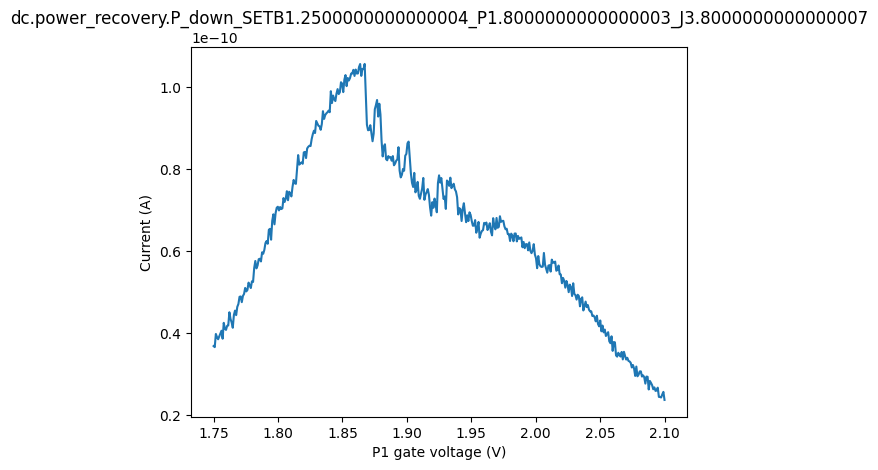

In [492]:
for p1p2 in load_p1p2:
    for setb in load_setb:
        for j in load_j:
            name = f"SETB{setb} P{p1p2} J{j}"
            print(f"Starting new run: {name}")
            reload(thresh=setb, p=p1p2, j=j)
            gettotarget()
            scan_p1(low=1.75, high=2.1, points=401, params=f"up {name}")
            scan_p1(low=2.1, high=1.75, points=401, params=f"down {name}")

In [306]:
tol

1e-12

In [308]:
monty.identifier

'dc.recovery'

In [323]:
?si.P1.

Signature: si.P1.soft_ramp(rate=None, step=None)
Docstring:
Set up a software ramp on the voltage parameter, saving the previous values
of step/delay if available
File:      c:\users\ld2007\documents\si_cmos_james\quench\libraries\qcodes_measurements\device\gate.py
Type:      method

# Push electrons out
Sweep both P1 and P2 down after loading to see electrons transition out of the dot. Use feedback

In [482]:
print(f"P1 = {si.P1()}\nP2 = {si.P2()}\nST = {si.ST()}")

P1 = 1.900002
P2 = 1.700003
ST = 3.700005


In [709]:
reload(thresh=1.1, p=1.45, j=3.5)  # WORKING LOAD=1.1,1.65,3.5

Flushing electrons...
Raising P1 and P2...
Loading electrons...
Reloaded in 95.73250246047974 seconds.


In [483]:
si.ST(3.52)

In [491]:
gettotarget()
lockin.R()

Target = 6.0000e-11, tol = 1e-12, initial ST = 3.521338

Final ST = 3.521338


5.9892285575e-11

In [463]:
si.P2(1.9)

Started new run kickout_scan.1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [05:56<00:00,  1.19s/it]


Run finished and took 0:05:56.837308.
Saving to kickout_scan.1.xz
Saving to experiment.yaml


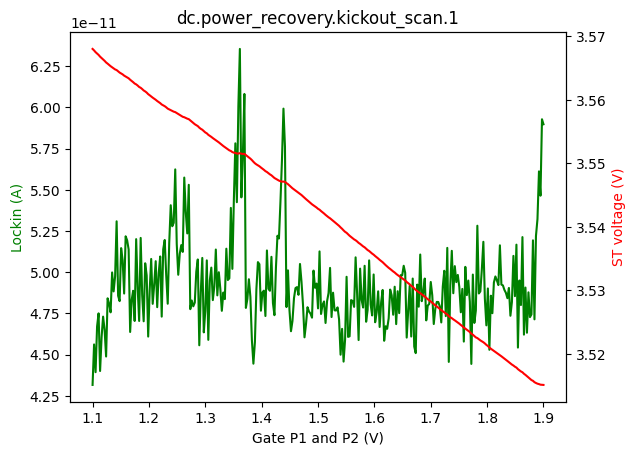

In [468]:
start = 1.9
end = 1.1
points = 301
stepsize = 10e-4

parameters = {
    "desc": "Sweep P1 and P2 down to remove electrons (feedback)",
    "lockin_amplitude": "Set to 10uV",
    "ST":   f"Fixed at {si.ST()}V (target of {target} on lockin, stepsize = {stepsize})",
    "SLB":  f"Fixed at {si.SLB()}V",
    "SRB":  f"Fixed at {si.SRB()}V",
    "SETB": f"Fixed at {si.SETB()}V",
    "J1": f"Fixed at {gb_control_si.VICL()}V",
    "P1": f"Ranged from {start}V -> {end}V in {points} points",
    "P2": f"Ranged from {start}V -> {end}V in {points} points",
    "temp": f"Mixing chamber {fridge.temp()} K",
    }

monty.newrun("kickout scan", parameters)

# gate voltage
gate_range = np.linspace(start, end, points)

X = np.zeros((points))
Y = np.zeros((points))
R = np.zeros((points))
P = np.zeros((points))
ST_drift = np.zeros(points)

with tqdm(total=points) as pbar, LivePlot(gate_range, xlabel="Gate voltage (P1 and P2) (V)", ylabel="Current (A)") as lplot:
    for (j, g) in enumerate(gate_range):
        si.P1(g)
        si.P2(g)
        time.sleep(0.5)
        
        ST_drift[j] = si.ST()
        X[j] = lockin.X()
        Y[j] = lockin.Y()
        R[j] = lockin.R()
        P[j] = lockin.P()
        
        pbar.update(1)
        lplot.update(R)
        
        feedback(si.ST, lockin, target, stepsize=stepsize, slope="up")


monty.save({"X": X, "Y": Y, "R": R, "P": P, "ST": ST_drift})


# Plot everything
fig, ax0 = plt.subplots()
ax1 = ax0.twinx()

ax0.plot(gate_range, R, "g-", label="Lockin")
ax0.set_ylabel("Lockin (A)", color="g")

# Plot ST history over time
ax1.plot(gate_range, ST_drift, "r-", label="ST gate")
ax1.set_ylabel("ST voltage (V)", color="r")

ax0.set_xlabel("Gate P1 and P2 (V)")
ax0.set_title(monty.identifier + "." + monty.runname)

monty.savefig(plt, "kickout")